# Introduction aux Modèles Plug-and-Play (PnP)

## Qu'est-ce que le Plug-and-Play (PnP) ?

Le concept de Plug-and-Play (PnP) appliqué à la résolution de problèmes inverses en traitement d'images permet de remplacer le terme de régularisation traditionnel par un débruiteur externe, sans nécessiter de modifications majeures dans l'algorithme principal. Cette approche modulaire augmente la flexibilité et la précision de l'algorithme, rendant possible l'adaptation rapide aux exigences spécifiques de différentes applications


## Exemple d'utilisation

#### Implémentation dans un algorithme de descente de gradient :

**Initialisation:**
- $x_0 \leftarrow \text{Image initiale bruitée}$
- $\lambda \leftarrow \text{Pas de descente}$
- $\tau \leftarrow \text{Poids de la régularisation}$
- $\theta \leftarrow \text{Nombre total d'itérations}$
- $D \leftarrow \text{Débruiteur (par exemple, U-net, DnCNN, ondelettes, etc..)}$

**Procédure:**
Pour $i$ de 1 à $\theta$ faire:
  - $x_i \leftarrow x_{i-1} - \lambda \times A^T(A(y_i) - y_i) + \tau \times ( x_i - D(x_{i}))$      # Mise à jour de l'image

**Retourner** $x_{\theta}$  # Image restaurée



Le terme $\tau \times (x_i - D(x_i))$ dans la mise à jour de $x_i$ remplace les formes classiques de régularisation telles que la norme L2 ou L1. Ce terme agit comme un régulateur en poussant $x_i$ vers l'image débruitée $D(x_i)$, intégrant ainsi une régularisation adaptative basée sur les caractéristiques apprises par le débruiteur.


## Pourquoi utiliser PnP ?

Les modèles PnP offrent plusieurs avantages significatifs :
- **Flexibilité** : Ils permettent d'intégrer facilement des débruiteurs avancés sans modifier le schéma global de l'algorithme de reconstruction.
- **Performance** : En intégrant les meilleurs débruiteurs disponibles, on peut souvent obtenir de meilleures performances en termes de qualité d'image restaurée.
- **Adaptabilité** : Les modèles PnP peuvent s'adapter à divers problèmes inverses tels que la déconvolution (défloutage), l'inpainting (restauration d'image) et la super-résolution.


## Applications


Les modèles PnP sont utilisés dans une variété de domaines, allant de la médecine (par exemple, l'imagerie par résonance magnétique) à la surveillance par caméra, où la qualité des images restaurées est cruciale pour l'analyse et la prise de décisions.

Dans ce projet, nous explorerons comment différents débruiteurs influencent la performance des méthodes de résolution de problèmes inverses en utilisant des techniques telles que la descente de gradient et des algorithmes proximaux.


---
## Sommaire

- #### 1 Défloutage
- #### 2 Défloutage à l'aveugle
- #### 3 Inpainting
- #### 4 Haute résolution
- #### 5 Tomographie

---


### Imports

In [1]:
from model import Unet
#from DeblurFCN import DeblurFCN
from pnp import pnp_admm
from utils import conv2d_from_kernel, compute_psnr, ImagenetDataset, myplot
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from PIL import Image, ImageFilter
import torchvision.transforms.functional as TF
import PIL.Image as Image
from torchvision.transforms.functional import to_pil_image, to_tensor
import torchvision.transforms as transforms
import scipy as scp
import pywt
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Chargement de l'image de test

In [2]:
test_image = Image.open('image/test_image.png').convert("RGB")
test_image = ImagenetDataset([]).test_transform(test_image)
channels, h, w = test_image.shape
test_image = test_image.unsqueeze(0).to(device)

### Débruiteur U-net

In [ ]:
#Téléchargement du réseau Unet déjà entrainé
import gdown
url = 'https://drive.google.com/file/d/1FFuauq-PUjY_kG3iiiHfDpHcG4Srl8mQ/view?usp=sharing'
output = "denoiser.pth"
gdown.download(url, output, quiet=False,fuzzy=True)

In [3]:
model = Unet(3, 3, chans=64).to(device)
model.load_state_dict(torch.load('denoiser.pth', map_location=device))
print('#Parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

#Parameters: 31025027


#### Débruiteur ondelettes

In [4]:
# Estimation du bruit
def EstimEcartTypeBruit(s, qmf):
    Lmax = pywt.dwt_max_level(len(s), pywt.Wavelet(qmf).dec_len)
    wsb = pywt.wavedec(s, qmf, mode='per', level=Lmax)
    mt = np.sqrt(2) * scp.special.erfinv(0.5)
    return np.median(np.abs(wsb[Lmax])) / mt

def SeuillageOndelette(SB, qmf, L, Seuil):
    WTB = pywt.wavedecn(SB, qmf, mode='per', level=L)
    arr, coeff_slices = pywt.coeffs_to_array(WTB)
    WTS = arr * (np.abs(arr) > Seuil)
    coeffs_from_arr = pywt.array_to_coeffs(WTS, coeff_slices)
    Srec = pywt.waverecn(coeffs_from_arr, qmf, mode='per')
    return Srec

def Debruit(S, qmf, sigma, T):
    Lmax = pywt.dwt_max_level(len(S), pywt.Wavelet(qmf).dec_len)
    Seuil = T * sigma
    Srec = SeuillageOndelette(S, qmf, Lmax, Seuil)
    return Srec

def translate_image(image, shift, direction):
    return np.roll(image, shift, axis=direction)

# Débruiteur ondelette avec translation
def DebruiteurOndelette(image_tensor, qmf='db1', shifts=[-1, 0, 1], device=device):
    image_np = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

    final_denoised_images = []
    for shift_x in shifts:
        for shift_y in shifts:
            # Translation de l'image
            translated_image = translate_image(image_np, shift_x, 0)  # Translation sur l'axe x
            translated_image = translate_image(translated_image, shift_y, 1)  # Puis sur l'axe y

            # Débruitage de chaque canal
            channels_denoised = []
            for i in range(translated_image.shape[2]):
                channel = translated_image[:, :, i]
                sigma = EstimEcartTypeBruit(channel, qmf)
                T = 3
                channel_denoised = Debruit(channel, qmf, sigma, T)
                channels_denoised.append(channel_denoised)

            denoised_image = np.stack(channels_denoised, axis=2)
            final_denoised_images.append(denoised_image)

    # Moyennage des images débruitées
    image_denoised_avg = np.mean(final_denoised_images, axis=0)
    image_denoised_tensor = torch.tensor(image_denoised_avg).permute(2, 0, 1).unsqueeze(0).to(device)
    return image_denoised_tensor


In [25]:
from torch import nn
def conv2d_from_kernel(kernel, channels, device, stride=1):
    """
    Returns nn.Conv2d and nn.ConvTranspose2d modules from 2D kernel, such that 
    nn.ConvTranspose2d is the adjoint operator of nn.Conv2d
    Arg:
        kernel: 2D kernel
        channels: number of image channels
    """
    kernel_size = kernel.shape
    kernel = kernel/kernel.sum()
    kernel = kernel.repeat(channels, 1, 1, 1)
    filter = nn.Conv2d(
        in_channels=channels, out_channels=channels,
        kernel_size=kernel_size, groups=channels, bias=False, stride=stride,
        padding=kernel_size[1]//2

    )
    filter.weight.data = kernel
    filter.weight.requires_grad = False

    filter_adjoint = nn.ConvTranspose2d(
        in_channels=channels, out_channels=channels,
        kernel_size=kernel_size, groups=channels, bias=False, stride=stride,
        padding=kernel_size[1]//2

    )
    filter_adjoint.weight.data = kernel
    filter_adjoint.weight.requires_grad = False

    return filter.to(device), filter_adjoint.to(device)


## Descente de gradient

In [13]:
def descente_gradient(image, model, forward, forward_adjoint, n_iter = 1e5, nu = 0.4, tau = 1e-2):
    y = forward(image)
    xk = forward_adjoint(forward(image))
    l_xk = []
    # Run plug and play
    for i in range(n_iter+1):
        xkplus1 = xk - nu * (forward_adjoint(forward(xk) - y) + tau * (xk - model(xk)))
        xkplus1 = xkplus1.clip(0,1)

        if i % 2000 == 0:
            print("Itération: ", i, "-" ,(torch.norm(xkplus1 - xk) / torch.norm(xk)).item())
            plt.imshow(xkplus1.permute(0,2,3,1).squeeze().cpu()); plt.title(f"Résultat à l'itération {i}")
            plt.show()

        l_xk.append((torch.norm(xkplus1 - xk) / torch.norm(xk)).cpu().item())
        xk = xkplus1
    
    return xk, l_xk

## Algorithme proximal

In [32]:
def proximal(image, model, forward, forward_adjoint, n_iter = 1e5, nu = 0.4):
    y = forward(image)
    xk = forward_adjoint(forward(image))
    l_xk = []
    # Run plug and play
    for i in range(n_iter+1):
        xkplus1 = model(xk - nu * forward_adjoint(forward(xk) - y))
        xkplus1 = xkplus1.clip(0,1)

        if i % 20 == 0:
            print("Itération: ", i, "-" ,(torch.norm(xkplus1 - xk) / torch.norm(xk)).item())
            plt.imshow(xkplus1.permute(0,2,3,1).squeeze().cpu()); plt.title(f"Résultat à l'itération {i}")
            plt.show()
        l_xk.append((torch.norm(xkplus1 - xk) / torch.norm(xk)).cpu().item())
        xk = xkplus1
    
    return xk, l_xk

## PnP défloutage avec descente de Gradient

In [51]:
# Initialisation des paramètres
kernel_size = 21
kernel_motion_blur = torch.ones((1, kernel_size))
forward, forward_adjoint = conv2d_from_kernel(kernel_motion_blur, channels, device)

 # Début Descente de gradient avec débruiteur ondelette # 
Itération:  0 - 0.007764897309243679


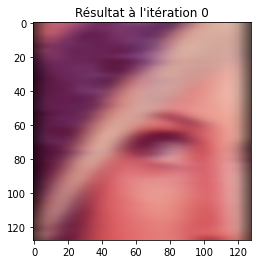

Itération:  2000 - 8.007708856894169e-06


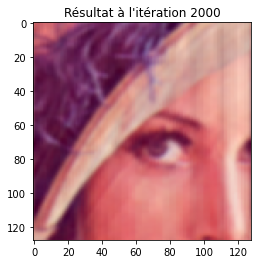

Itération:  4000 - 3.57112708115892e-06


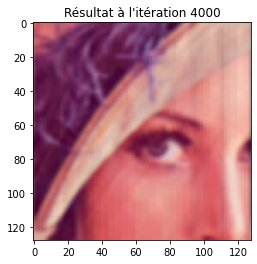

 # Fin Descente de gradient avec débruiteur ondelette # 
 ---> temps de calcul pour 6000 itérations: 182.795006275177 sec

 # Début Descente de gradient avec débruiteur Unet # 
Itération:  0 - 0.007767603732645512


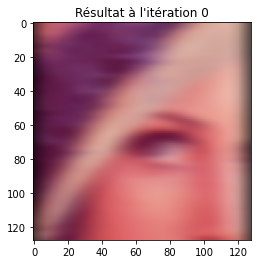

Itération:  2000 - 8.992704351840075e-06


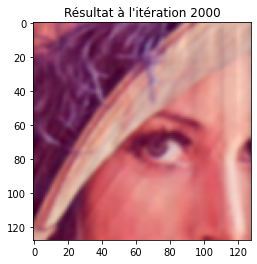

Itération:  4000 - 4.005912160209846e-06


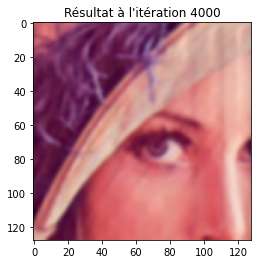

 # Fin Descente de gradient avec débruiteur Unet# 
 ---> temps de calcul pour 6000 itérations: 732.2389793395996 sec

 # Début Descente de gradient avec simple régularisation L2 # 
Itération:  0 - 0.0073916614055633545


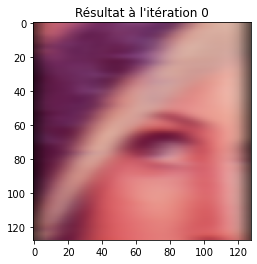

Itération:  2000 - 1.1714905667759012e-06


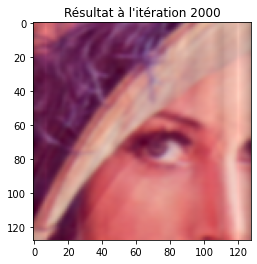

Itération:  4000 - 6.64333441591225e-08


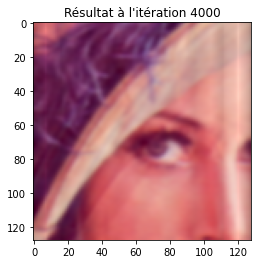

 # Fin Descente de gradient avec simple régularisation L2 # 
 ---> temps de calcul pour 6000 itérations: 1.0536253452301025 sec


In [27]:
##### Défloutage avec Descente de gradient ####
n_iter = 6000
# Ondelettes
print(" # Début Descente de gradient avec débruiteur ondelette # ")
t0 = time.time()
x_DG_ond, l_DG_ond = descente_gradient(test_image, DebruiteurOndelette, forward, forward_adjoint, n_iter=n_iter, nu=0.1, tau=1e-2)
t1 = time.time()
print(" # Fin Descente de gradient avec débruiteur ondelette # ")
print(f" ---> temps de calcul pour {n_iter} itérations: {t1-t0} sec")


# Unet
print("\n # Début Descente de gradient avec débruiteur Unet # ")
t0 = time.time()
with torch.no_grad():
    model.eval()
    x_DG_unet, l_DG_unet = descente_gradient(test_image, model, forward, forward_adjoint, n_iter=n_iter, nu=0.1, tau=1e-2)
t1 = time.time()
print(" # Fin Descente de gradient avec débruiteur Unet# ")
print(f" ---> temps de calcul pour {n_iter} itérations: {t1-t0} sec")

# Regularisation L2
print("\n # Début Descente de gradient avec simple régularisation L2 # ")
t0 = time.time()
x_DG_l2, l_DG_l2 = descente_gradient(test_image, lambda x:0, forward, forward_adjoint, n_iter=n_iter, nu=0.1, tau=1e-2)
t1 = time.time()
print(" # Fin Descente de gradient avec simple régularisation L2 # ")
print(f" ---> temps de calcul pour {n_iter} itérations: {t1-t0} sec")

#x_ondelette, l = proximal(test_image, DebruiteurOndelette, forward, forward_adjoint, n_iter=1000, nu=0.5)
#x_L2, l2 = descente_gradient(test_image, lambda x:0, forward, forward_adjoint, n_iter=100, nu=0.4, tau=1e-2)



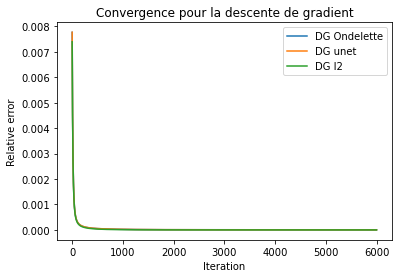

In [28]:
#Affichage de l'erreur
plt.plot(l_DG_ond,label="DG Ondelette") 
plt.plot(l_DG_unet,label="DG unet")
plt.plot(l_DG_l2,label="DG l2")

plt.xlabel('Iteration') 
plt.ylabel('Relative error')
plt.title('Convergence pour la descente de gradient')
plt.legend()
plt.show()

In [29]:
#### PSNR ####
print('PSNR DG ondelette [dB]: {:.2f}'.format(compute_psnr(x_DG_ond, test_image)))
print('PSNR DG Unet [dB]: {:.2f}'.format(compute_psnr(x_DG_unet, test_image)))
print('PSNR DG L2 [dB]: {:.2f}'.format(compute_psnr(x_DG_l2, test_image)))

PSNR DG ondelette [dB]: 32.49
PSNR DG Unet [dB]: 34.42
PSNR DG L2 [dB]: 29.35


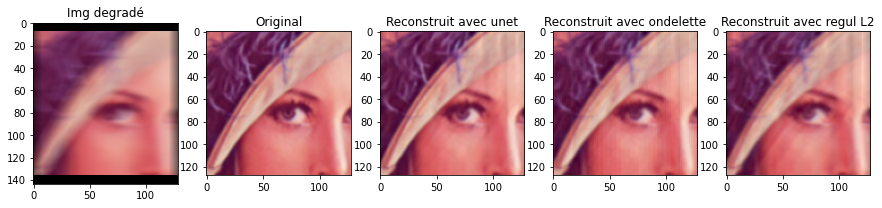

In [30]:

plt.figure(figsize=(15,10))
y = forward(test_image)
plt.subplot(1,5,1); plt.imshow(y.permute(0,2,3,1).squeeze().cpu()); plt.title('Img degradé')
plt.subplot(1,5,2); plt.imshow(test_image.permute(0,2,3,1).squeeze().cpu()); plt.title('Original')
plt.subplot(1,5,3); plt.imshow(x_DG_unet.permute(0,2,3,1).squeeze().cpu()); plt.title('Reconstruit avec unet')
plt.subplot(1,5,4); plt.imshow(x_DG_ond.permute(0,2,3,1).squeeze().cpu()); plt.title('Reconstruit avec ondelette')
plt.subplot(1,5,5); plt.imshow(x_DG_l2.permute(0,2,3,1).squeeze().cpu()); plt.title('Reconstruit avec regul L2')
plt.show()

## PnP défloutage avec proximal

 # Début Algo proximal avec débruiteur ondelette # 
Itération:  0 - 0.044336218386888504


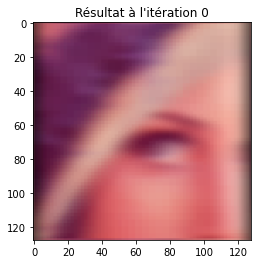

Itération:  20 - 0.007627519778907299


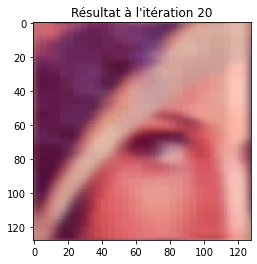

Itération:  40 - 0.007070702500641346


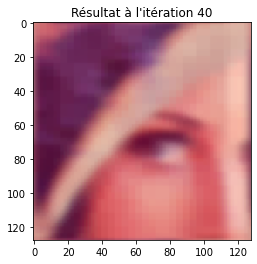

Itération:  60 - 0.006973850540816784


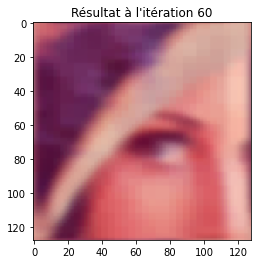

Itération:  80 - 0.006939033977687359


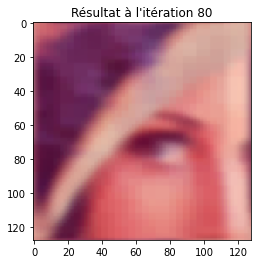

Itération:  100 - 0.00693557970225811


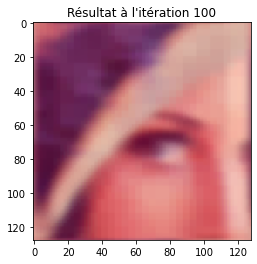

 # Fin Algo proximal avec débruiteur ondelette # 
 ---> temps de calcul pour 100 itérations: 3.4942924976348877 sec

 # Début Algo proximal avec débruiteur Unet # 
Itération:  0 - 0.03942244127392769


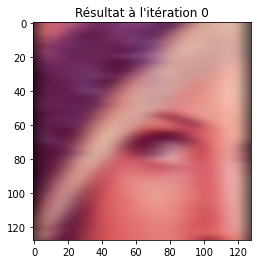

Itération:  20 - 0.0024003845173865557


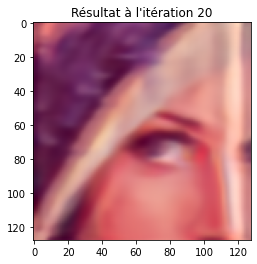

Itération:  40 - 0.002993726870045066


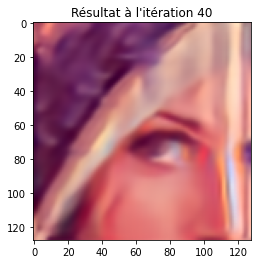

Itération:  60 - 0.0027225182857364416


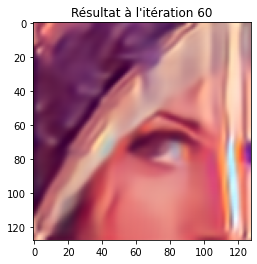

Itération:  80 - 0.002942035673186183


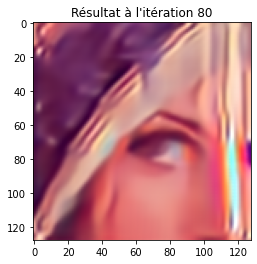

Itération:  100 - 0.0022914891596883535


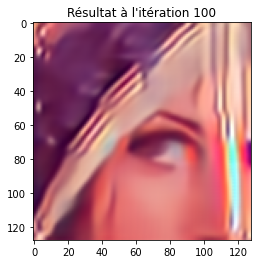

 # Fin Algo proximal avec débruiteur Unet# 
 ---> temps de calcul pour 100 itérations: 12.934496641159058 sec


In [34]:
##### Défloutage avec proximal ####
n_iter = 100
# Ondelettes
print(" # Début Algo proximal avec débruiteur ondelette # ")
t0 = time.time()
x_prox_ond, l_prox_ond = proximal(test_image, DebruiteurOndelette, forward, forward_adjoint, n_iter=n_iter, nu=0.5)
t1 = time.time()
print(" # Fin Algo proximal avec débruiteur ondelette # ")
print(f" ---> temps de calcul pour {n_iter} itérations: {t1-t0} sec")


# Unet
print("\n # Début Algo proximal avec débruiteur Unet # ")
t0 = time.time()
with torch.no_grad():
    model.eval()
    x_prox_unet, l_prox_unet = proximal(test_image, model, forward, forward_adjoint, n_iter=n_iter, nu=0.5)

t1 = time.time()
print(" # Fin Algo proximal avec débruiteur Unet# ")
print(f" ---> temps de calcul pour {n_iter} itérations: {t1-t0} sec")

# # Regularisation L2
# print("\n # Début Algo proximal avec simple régularisation L2 # ")
# t0 = time.time()
# x_prox_l2, l_prox_l2  = proximal(test_image, lambda x:0, forward, forward_adjoint, n_iter=n_iter, nu=0.5)

# t1 = time.time()
# print(" # Fin Algo proximal avec simple régularisation L2 # ")
# print(f" ---> temps de calcul pour {n_iter} itérations: {t1-t0} sec")





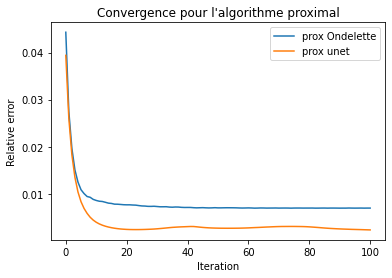

In [36]:
#Affichage de l'erreur
plt.plot(l_prox_ond,label="prox Ondelette") 
plt.plot(l_prox_unet,label="prox unet")
#plt.plot(l_prox_l2,label="DG l2")

plt.xlabel('Iteration') 
plt.ylabel('Relative error')
plt.title("Convergence pour l'algorithme proximal")
plt.legend()
plt.show()

In [37]:
#### PSNR ####
print('PSNR prox ondelette [dB]: {:.2f}'.format(compute_psnr(x_prox_ond, test_image)))
print('PSNR prox Unet [dB]: {:.2f}'.format(compute_psnr(x_prox_unet, test_image)))
# print('PSNR prox L2 [dB]: {:.2f}'.format(compute_psnr(x_DG_l2, test_image)))

PSNR prox ondelette [dB]: 24.32
PSNR prox Unet [dB]: 21.57


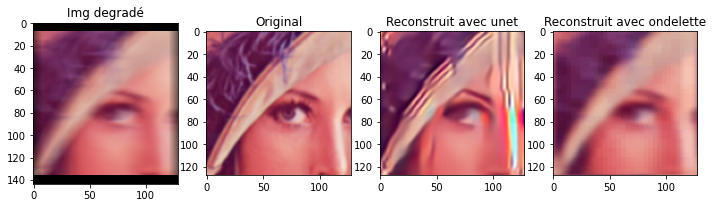

In [38]:
plt.figure(figsize=(15,10))
y = forward(test_image)
plt.subplot(1,5,1); plt.imshow(y.permute(0,2,3,1).squeeze().cpu()); plt.title('Img degradé')
plt.subplot(1,5,2); plt.imshow(test_image.permute(0,2,3,1).squeeze().cpu()); plt.title('Original')
plt.subplot(1,5,3); plt.imshow(x_prox_unet.permute(0,2,3,1).squeeze().cpu()); plt.title('Reconstruit avec unet')
plt.subplot(1,5,4); plt.imshow(x_prox_ond.permute(0,2,3,1).squeeze().cpu()); plt.title('Reconstruit avec ondelette')
# plt.subplot(1,5,5); plt.imshow(x_DG_l2.permute(0,2,3,1).squeeze().cpu()); plt.title('Reconstruit avec regul L2')
plt.show()

## PnP défloutage avec admm

In [52]:
y = forward(test_image)

In [53]:
with torch.no_grad():
    model.eval()
    x_admm_unet = pnp_admm(y, forward, forward_adjoint, model)
    x_admm_unet = x.clip(0,1)

In [54]:
x_admm_ond = pnp_admm(y, forward, forward_adjoint, DebruiteurOndelette)
x_admm_ond = x.clip(0,1)

In [55]:
## PSNR ##
print('PSNR admm avec unet [dB]: {:.2f}'.format(compute_psnr(x_admm_unet, test_image)))
print('PSNR admm avec ondelette [dB]: {:.2f}'.format(compute_psnr(x_admm_ond, test_image)))

PSNR admm avec unet [dB]: 47.74
PSNR admm avec ondelette [dB]: 47.74


Text(0.5, 1.0, 'Reconstruit avec ondelette')

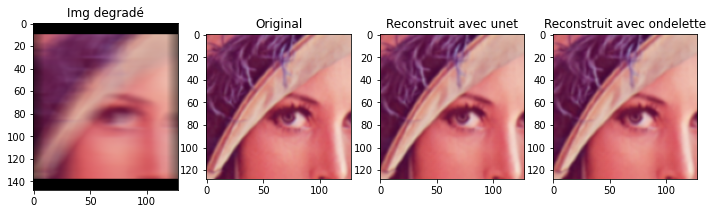

In [56]:
plt.figure(figsize=(15,10))
y = forward(test_image)
plt.subplot(1,5,1); plt.imshow(y.permute(0,2,3,1).squeeze().cpu()); plt.title('Img degradé')
plt.subplot(1,5,2); plt.imshow(test_image.permute(0,2,3,1).squeeze().cpu()); plt.title('Original')
plt.subplot(1,5,3); plt.imshow(x_admm_unet.permute(0,2,3,1).squeeze().cpu()); plt.title('Reconstruit avec unet')
plt.subplot(1,5,4); plt.imshow(x_admm_ond.permute(0,2,3,1).squeeze().cpu()); plt.title('Reconstruit avec ondelette')

## PnP Inpainting

Itération:  0 - 0.0025117513723671436
Itération:  100 - 0.0014166752807796001
Itération:  200 - 0.00112445920240134
Itération:  300 - 0.0008956226520240307
Itération:  400 - 0.0007191671174950898
Itération:  500 - 0.0005831411690451205
Itération:  600 - 0.0004775441193487495
Itération:  700 - 0.00039480600389651954
Itération:  800 - 0.00032937360811047256
Itération:  900 - 0.00027714346651919186
Itération:  1000 - 0.00023509391758125275
Itération:  1100 - 0.00020091635815333575
Itération:  1200 - 0.00017293571727350354
Itération:  1300 - 0.00014986096357461065
Itération:  1400 - 0.00013067774125374854
Itération:  1500 - 0.00011463902774266899
Itération:  1600 - 0.00010119607031811029
Itération:  1700 - 8.982762665254995e-05
Itération:  1800 - 8.01755377324298e-05
Itération:  1900 - 7.196793012553826e-05
Itération:  2000 - 6.492850661743432e-05
Itération:  2100 - 5.8868889027507976e-05
Itération:  2200 - 5.361319927033037e-05
Itération:  2300 - 4.905341484118253e-05
Itération:  2400 - 4

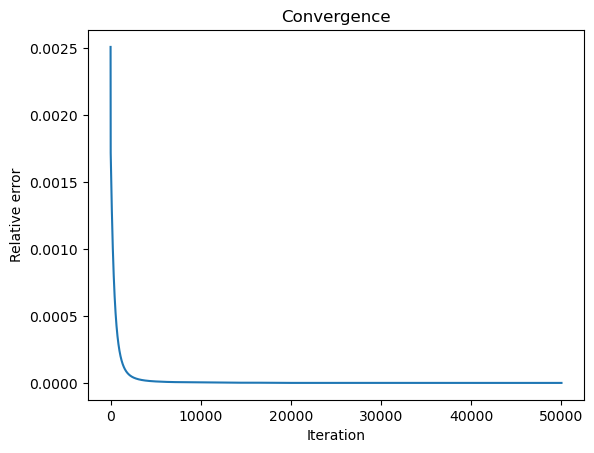

In [119]:
# Initialisation des paramètres
mask = torch.rand(1,1,h,w).to(device)
mask = mask < 0.5

def forward(x):
    return x*mask
forward_adjoint = forward

# Inpainting
with torch.no_grad():
    x_unet, l_unet = descente_gradient(test_image, model, forward, forward_adjoint, n_iter=50000, nu=0.4, tau=1e-2)
    x_L2, l2 = descente_gradient(test_image, lambda x:0, forward, forward_adjoint, n_iter=50000, nu=0.4, tau=1e-2)

# Plot convergence
plt.plot(l_unet) 
plt.xlabel('Iteration') 
plt.ylabel('Relative error')
plt.title('Convergence')
plt.show()

PSNR with denoiser [dB]: 36.31
PSNR [dB]: 7.79


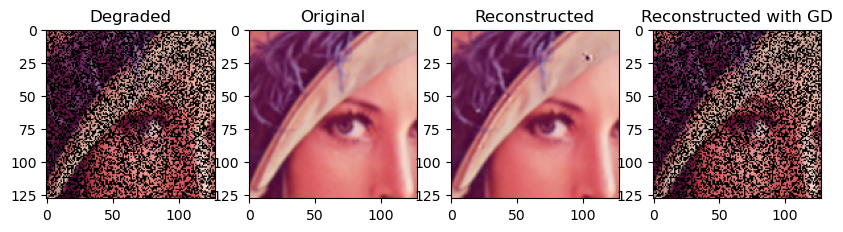

In [120]:
print('PSNR with denoiser [dB]: {:.2f}'.format(compute_psnr(x_unet, test_image)))
print('PSNR [dB]: {:.2f}'.format(compute_psnr(x_L2, test_image)))
plt.figure(figsize=(10,5))
y = forward(test_image)
#image_redimensionnee = ImagenetDataset([]).test_transform(image_redimensionnee)
plt.subplot(1,4,1); plt.imshow(y.permute(0,2,3,1).squeeze().cpu()); plt.title('Degraded')
plt.subplot(1,4,2); plt.imshow(test_image.permute(0,2,3,1).squeeze().cpu()); plt.title('Original')
plt.subplot(1,4,3); plt.imshow(x_unet.permute(0,2,3,1).squeeze().cpu()); plt.title('Reconstructed')
plt.subplot(1,4,4); plt.imshow(x_L2.permute(0,2,3,1).squeeze().cpu()); plt.title('Reconstructed with GD')
plt.show()

### PnP Super-resolution

In [23]:
# Super-resolultion
kernel_size = 4
kernel_downsampling = torch.ones((kernel_size, kernel_size))
forward, forward_adjoint = conv2d_from_kernel(kernel_downsampling, channels, device, stride=kernel_size)

# Inpainting
with torch.no_grad():
    x_unet, l_unet = descente_gradient(test_image, model, forward, forward_adjoint, n_iter=5000, nu=0.5, tau=1e-2)
    #x_unet, l_unet = proximal(test_image, DebruiteurOndelette, forward, forward_adjoint, n_iter=10000, nu=0.01)
    x_L2, l2 = descente_gradient(test_image, lambda x:0, forward, forward_adjoint, n_iter=1000, nu=0.1, tau=1e-3)

# Plot convergence
plt.plot(l_unet) 
plt.xlabel('Iteration') 
plt.ylabel('Relative error')
plt.title('Convergence')
plt.show()

Itération:  0 - 0.46874186396598816
Itération:  1000 - 1.9040546249016188e-05
Itération:  2000 - 1.4159134479996283e-05
Itération:  3000 - 1.3281659448693972e-05
Itération:  4000 - 1.3368538930080831e-05


PSNR with denoiser [dB]: 29.06
PSNR [dB]: 26.76


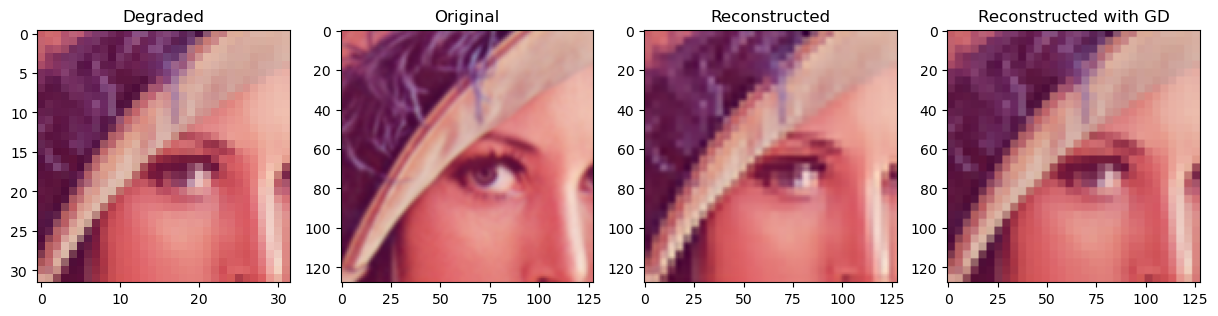

In [ ]:
print('PSNR with denoiser [dB]: {:.2f}'.format(compute_psnr(x_unet, test_image)))
print('PSNR [dB]: {:.2f}'.format(compute_psnr(x_L2, test_image)))
plt.figure(figsize=(15,10))
y = forward(test_image)
#image_redimensionnee = ImagenetDataset([]).test_transform(image_redimensionnee)
plt.subplot(1,4,1); plt.imshow(y.permute(0,2,3,1).squeeze().cpu()); plt.title('Degraded')
plt.subplot(1,4,2); plt.imshow(test_image.permute(0,2,3,1).squeeze().cpu()); plt.title('Original')
plt.subplot(1,4,3); plt.imshow(x_unet.permute(0,2,3,1).squeeze().cpu()); plt.title('Reconstructed')
plt.subplot(1,4,4); plt.imshow(x_L2.permute(0,2,3,1).squeeze().cpu()); plt.title('Reconstructed with GD')
plt.show()

## PnP Transfomé de Randon

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon, resize
from skimage.data import shepp_logan_phantom

def generate_radon_projections(image, theta):
    # Génère les projections Radon de l'image donnée pour des angles spécifiés
    sinogram = radon(image, theta=theta, circle=True)
    return sinogram

def compute_psnr2(img1, img2):
    mse = np.mean((img1*255 - img2*255) ** 2)
    return 20 * np.log10(255.0 / np.sqrt(mse))

def model2(x, model):
    sinogram = x
    image_rgb = np.stack([sinogram, sinogram, sinogram], axis=-1)
    image_tensor = torch.tensor(image_rgb, dtype=torch.float32)
    image_tensor = image_tensor.permute(2, 0, 1)
    sinogram = image_tensor.unsqueeze(0)
    x = model(sinogram)
    x = x.squeeze(0)
    x = x.mean(dim=0)
    return x.detach().numpy()

def descente_gradient(image, model, n_iter = 1e5, nu = 0.4, tau = 1e-2):
    y = radon(image, theta=theta, circle=True)
    xk = iradon(y, theta=theta,filter_name= None, circle=True)
    l_xk = []
    # Run plug and play
    for i in range(n_iter):
        xkplus1 = xk - nu * iradon(radon(xk, theta=theta, circle=True) - y, theta=theta,filter_name=None, circle=True) + tau * (xk - model(xk))
        xkplus1 = xkplus1.clip(0,1)

        xk = xkplus1
    
    return xk, l_xk


# Génération de l'image test et des projections Radon
original_image = shepp_logan_phantom()
image = resize(original_image, (128, 128), mode='reflect', anti_aliasing=True)
theta = np.linspace(0., 180., max(image.shape), endpoint=False)


# Initialisation des paramètres
x_ondelette , l = descente_gradient(image, lambda x:model2(x,DebruiteurOndelette), n_iter=100, nu=0.01, tau=1e-2)
x_Unet, l = descente_gradient(image, lambda x:model2(x,model), n_iter=100, nu=0.01, tau=1e-2)
x_L2, l = descente_gradient(image, lambda x:0, n_iter=100, nu=0.01, tau=1e-2)

PSNR [dB] with ondelettes: 37.43
PSNR [dB] with Unet: 33.44
PSNR [dB] with L2: 33.13


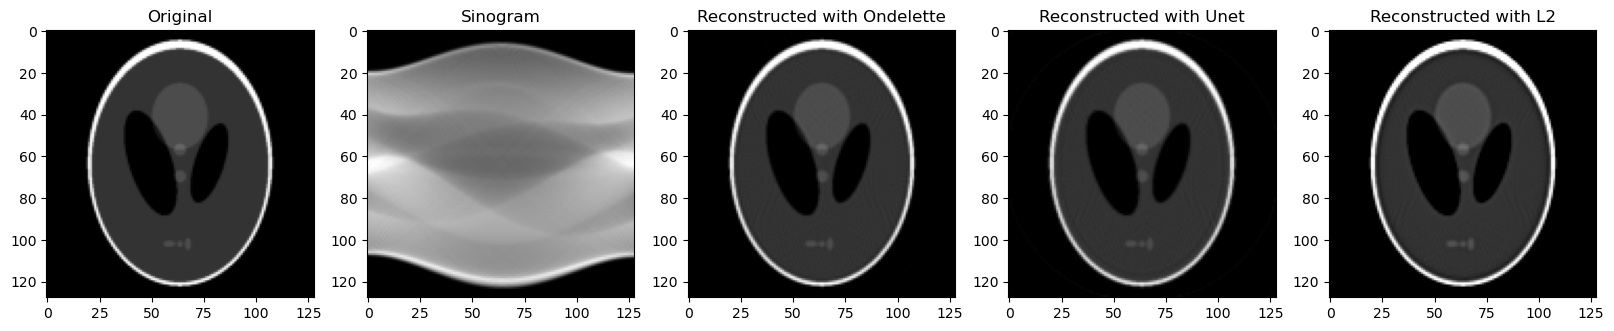

In [30]:
sinogram = generate_radon_projections(image, theta)
# Afficcher le psnr
print('PSNR [dB] with ondelettes: {:.2f}'.format(compute_psnr2(x_ondelette, image)))
print('PSNR [dB] with Unet: {:.2f}'.format(compute_psnr2(x_Unet, image)))
print('PSNR [dB] with L2: {:.2f}'.format(compute_psnr2(x_L2, image)))


plt.figure(figsize=(20,15))
plt.subplot(1,5,1); plt.imshow(image, cmap='gray'); plt.title('Original')
plt.subplot(1,5,2); plt.imshow(sinogram, cmap='gray'); plt.title('Sinogram')
plt.subplot(1,5,3); plt.imshow(x_ondelette, cmap='gray'); plt.title('Reconstructed with Ondelette')
plt.subplot(1,5,4); plt.imshow(x_Unet, cmap='gray'); plt.title('Reconstructed with Unet')
plt.subplot(1,5,5); plt.imshow(x_L2, cmap='gray'); plt.title('Reconstructed with L2')
plt.show()